In [1]:
import os

# 0. Setup Data Paths

nhanes_demo_dir = "./data/nhanes-demographics/"
demo_path_2011 = os.path.join(nhanes_demo_dir, "demo-2011-12.xpt")
demo_path_2013 = os.path.join(nhanes_demo_dir, "demo-2013-14.xpt")

nhanes_step_count_dir = "./data/nhanes-step-count/"
ac_path = os.path.join(nhanes_step_count_dir, "nhanes_1440_AC.csv.xz")
mims_path = os.path.join(nhanes_step_count_dir, "nhanes_1440_PAXMTSM.csv.xz")

nhanes_lab_dir = "./data/nhanes-lab/"
ghb_path_2011 = os.path.join(nhanes_lab_dir, "ghb-2011-12.xpt")
ghb_path_2013 = os.path.join(nhanes_lab_dir, "ghb-2013-14.xpt")

nhanes_questionnaire_dir = "./data/nhanes-questionnaire/"
bpq_path_2011 = os.path.join(nhanes_questionnaire_dir, "bpq-2011-12.xpt")
bpq_path_2013 = os.path.join(nhanes_questionnaire_dir, "bpq-2013-14.xpt")

nhanes_exam_dir = "./data/nhanes-examination/"
bmx_path_2011 = os.path.join(nhanes_exam_dir, "bmx-2011-12.xpt")
bmx_path_2013 = os.path.join(nhanes_exam_dir, "bmx-2013-14.xpt")

In [2]:
import pandas as pd

# 1. Load NHANES Step-Count Data

print("Loading Wearable Movement Data... (this may take a few minutes)")

ac_df = pd.read_csv(ac_path, dtype={"SEQN": "Int64"}, low_memory=False)
mims_df = pd.read_csv(mims_path, dtype={"SEQN": "Int64"}, low_memory=False)

print("Wearable Data Shape:")
print("- Activity Counts:", ac_df.shape)
print("- MIMS:", mims_df.shape)

Loading Wearable Movement Data... (this may take a few minutes)
Wearable Data Shape:
- Activity Counts: (130186, 1443)
- MIMS: (130186, 1443)


In [3]:
import numpy as np

# 2. Feature Engineering for NHANES Step-Count Data

print("Computing Wearable Data Features...")

# Compute Activity Counts Features
ac_minute_cols = [c for c in ac_df.columns if c.startswith("min_")]
ac_df["daily_AC"] = ac_df[ac_minute_cols].sum(axis=1, numeric_only=True)
ac_agg = ac_df.groupby("SEQN").agg(sd_daily_AC=("daily_AC", "std")).reset_index()
ac_agg["sd_daily_AC"] = ac_agg["sd_daily_AC"].fillna(0.0)

selected_columns = ["SEQN", "sd_daily_AC"]
df = ac_agg[selected_columns].copy()

# Compute MIMS Activity Intensity Bins
mims_minute_cols = [c for c in mims_df.columns if c.startswith("min_")]
mims_values = mims_df[mims_minute_cols].values.flatten()
mims_values_nonzero = mims_values[mims_values > 0]  # Exclude invalid data (zeros)

p25 = np.percentile(mims_values_nonzero, 25)
p95 = np.percentile(mims_values_nonzero, 95)

print(f"Computed MIMS Intensity Thresholds:")
print(f"Sedentary: MIMS > 0 and < {p25:.1f}")
print(f"Vigorous: MIMS > {p95:.1f}")

mims_vals = mims_df[mims_minute_cols].values
sedentary_mins = ((mims_vals > 0) & (mims_vals < p25)).sum(axis=1)
vigorous_mins = (mims_vals >= p95).sum(axis=1)
mims_df["sedentary_mins"] = sedentary_mins
mims_df["vigorous_mins"] = vigorous_mins

mims_agg = mims_df.groupby("SEQN").agg(
    mean_sedentary_mins=("sedentary_mins", "mean"),
    mean_vigorous_mins=("vigorous_mins", "mean"),
).reset_index()

df = df.merge(mims_agg, on="SEQN", how="inner")

df.describe()

Computing Wearable Data Features...
Computed MIMS Intensity Thresholds:
Sedentary: MIMS > 0 and < 1.0
Vigorous: MIMS > 36.9


,SEQN,sd_daily_AC,mean_sedentary_mins,mean_vigorous_mins
count,14693.0,1.469300e+04,14693.000000,14693.000000
mean,73182.610223,1.062692e+06,234.660112,47.042718
std,6486.170446,4.441004e+05,201.927361,45.543309
min,62161.0,0.000000e+00,0.000000,0.000000
25%,67312.0,7.569292e+05,99.000000,12.333333
50%,74099.0,1.028766e+06,144.888889,32.500000
75%,78969.0,1.333697e+06,333.666667,68.888889
max,83731.0,7.410255e+06,1280.888889,409.444444


In [4]:
# Load NHANES Demographic Data + Merge Features
demo_2011 = pd.read_sas(demo_path_2011, format="xport")
demo_2013 = pd.read_sas(demo_path_2013, format="xport")

demo = pd.concat([demo_2011, demo_2013], ignore_index=True)
# RIAGENDR: Gender
# RIDAGEYR: Age in Years at Screening
# RIDRETH3: Race/Hispanic Origin
# DMDEDUC2: Education Level
selected_columns = ["SEQN", "RIAGENDR", "RIDAGEYR", "RIDRETH3", "DMDEDUC2"]
demo = demo[selected_columns].copy()
demo = demo.dropna()
demo = demo.rename(
    columns={
        'RIAGENDR': 'gender', 
        'RIDAGEYR': 'age_in_years_at_screening', 
        'RIDRETH3': 'race',
        'DMDEDUC2': 'education_level'
    }
)
demo = demo[demo["age_in_years_at_screening"] >= 20]
demo['gender'] = demo['gender'].map(lambda x: 1 if x == 1 else 0)


df = df.merge(demo, on="SEQN", how="inner")

df.describe()

,SEQN,sd_daily_AC,mean_sedentary_mins,mean_vigorous_mins,gender,age_in_years_at_screening,race,education_level
count,9504.0,9.504000e+03,9504.000000,9504.000000,9504.000000,9504.000000,9504.000000,9504.000000
mean,72976.623001,9.533868e+05,244.729864,28.968943,0.479693,49.193708,3.386890,3.516309
std,6481.96767,4.032724e+05,199.697663,31.546606,0.499614,17.553006,1.475408,1.245827
min,62161.0,0.000000e+00,0.000000,0.000000,0.000000,20.000000,1.000000,1.000000
25%,67193.75,6.818534e+05,108.444444,7.444444,0.000000,34.000000,3.000000,3.000000
50%,73722.5,9.186228e+05,159.777778,19.888889,0.000000,49.000000,3.000000,4.000000
75%,78836.5,1.184437e+06,355.888889,40.000000,1.000000,63.000000,4.000000,5.000000
max,83729.0,5.098803e+06,1280.888889,343.666667,1.000000,80.000000,7.000000,9.000000


In [5]:
# 3. Load NHANES Questionnaire Data + Merge Features

bpq_2011 = pd.read_sas(bpq_path_2011, format="xport")
bpq_2013 = pd.read_sas(bpq_path_2013, format="xport")

bpq = pd.concat([bpq_2011, bpq_2013], ignore_index=True)
# BPQ020: Ever told you had high blood pressure
# BPQ080: Doctor told you - high cholesterol level
selected_columns = ["SEQN", "BPQ020", "BPQ080"]
bpq = bpq[selected_columns].copy()
bpq = bpq.dropna()
bpq = bpq.rename(columns={'BPQ020': 'high_blood_pressure', 'BPQ080': 'high_cholesterol'})
bpq['high_blood_pressure'] = bpq['high_blood_pressure'].map(lambda x: 1 if x == 1 else 0)
bpq['high_cholesterol'] = bpq['high_cholesterol'].map(lambda x: 1 if x == 1 else 0)

df = df.merge(bpq, on="SEQN", how="inner")

df.describe()

,SEQN,sd_daily_AC,mean_sedentary_mins,mean_vigorous_mins,gender,age_in_years_at_screening,race,education_level,high_blood_pressure,high_cholesterol
count,9503.0,9.503000e+03,9503.000000,9503.000000,9503.000000,9503.000000,9503.000000,9503.000000,9503.000000,9503.000000
mean,72977.370515,9.533777e+05,244.740861,28.967981,0.479743,49.195096,3.386615,3.516363,0.373461,0.346522
std,6481.899066,4.032927e+05,199.705292,31.548126,0.499616,17.553407,1.475242,1.245882,0.483748,0.475887
min,62161.0,0.000000e+00,0.000000,0.000000,0.000000,20.000000,1.000000,1.000000,0.000000,0.000000
25%,67194.5,6.818321e+05,108.444444,7.444444,0.000000,34.000000,3.000000,3.000000,0.000000,0.000000
50%,73723.0,9.183659e+05,159.777778,19.888889,0.000000,49.000000,3.000000,4.000000,0.000000,0.000000
75%,78837.0,1.184484e+06,356.000000,40.000000,1.000000,63.000000,4.000000,5.000000,1.000000,1.000000
max,83729.0,5.098803e+06,1280.888889,343.666667,1.000000,80.000000,7.000000,9.000000,1.000000,1.000000


In [6]:
# 4. Load NHANES Exammination Data + Merge Features

bmx_2011 = pd.read_sas(bmx_path_2011, format="xport")
bmx_2013 = pd.read_sas(bmx_path_2013, format="xport")

bmx = pd.concat([bmx_2011, bmx_2013], ignore_index=True)
# BMXBMI: Body Mass Index (BMI)
# BMXWAIST: Waist Circumference
selected_columns = ["SEQN", "BMXBMI", "BMXWAIST"]
bmx = bmx[selected_columns].copy()
bmx = bmx.dropna()
bmx = bmx.rename(columns={'BMXBMI': 'body_mass_index', 'BMXWAIST': 'waist_circumference'})
df = df.merge(bmx, on="SEQN", how="inner")

df.describe()

,SEQN,sd_daily_AC,mean_sedentary_mins,mean_vigorous_mins,gender,age_in_years_at_screening,race,education_level,high_blood_pressure,high_cholesterol,body_mass_index,waist_circumference
count,9071.0,9.071000e+03,9071.000000,9071.000000,9071.000000,9071.000000,9071.000000,9071.000000,9071.000000,9071.000000,9071.000000,9071.000000
mean,72988.371514,9.667010e+05,242.795472,29.692995,0.483519,48.681292,3.380994,3.529710,0.364017,0.343953,28.997453,99.070687
std,6485.837203,3.981667e+05,198.462172,31.552339,0.499756,17.313675,1.481800,1.234105,0.481180,0.475052,6.861597,16.421702
min,62161.0,0.000000e+00,0.000000,0.000000,0.000000,20.000000,1.000000,1.000000,0.000000,0.000000,14.100000,55.500000
25%,67196.5,6.979412e+05,107.888889,8.333333,0.000000,34.000000,3.000000,3.000000,0.000000,0.000000,24.100000,87.200000
50%,73741.0,9.288503e+05,157.111111,20.666667,0.000000,48.000000,3.000000,4.000000,0.000000,0.000000,27.900000,97.500000
75%,78853.0,1.192462e+06,351.666667,40.666667,1.000000,63.000000,4.000000,5.000000,1.000000,1.000000,32.500000,108.500000
max,83729.0,5.098803e+06,1280.888889,343.666667,1.000000,80.000000,7.000000,9.000000,1.000000,1.000000,82.100000,177.900000


In [7]:
# 5. Load NHANES Laboratory Glycohemoglobin Data + Calculate Ground Truth Diabetes Binary

print("Loading Lab A1C Data...")

ghb_2011 = pd.read_sas("./data/nhanes-lab/ghb-2011-12.xpt", format="xport")
ghb_2013 = pd.read_sas("./data/nhanes-lab/ghb-2013-14.xpt", format="xport")

print("Lab Data Shape:")
print("- GHB 2011-2012:", ghb_2011.shape)
print("- GHB 2013-2014:", ghb_2013.shape)

print("Calculating ground truth with A1C lab data...")
ghb_2011 = ghb_2011[["SEQN", "LBXGH"]].rename(columns={"LBXGH": "a1c_2011"})
ghb_2013 = ghb_2013[["SEQN", "LBXGH"]].rename(columns={"LBXGH": "a1c_2013"})

# Combine 2011-12 and 2013-14 data
ghb = pd.concat([ghb_2011, ghb_2013], ignore_index=True)
ghb["a1c"] = ghb["a1c_2011"].combine_first(ghb["a1c_2013"])
ghb = ghb.dropna(subset=["a1c"])
ghb = ghb.drop_duplicates(subset=["SEQN"], keep="first")

# A1C Diabetes Criteria (We include prediabetes as diabetes):
#   normal < 5.7
#   prediabetes 5.7-6.4
#   diabetes >= 6.5
ghb["diabetes_binary"] = (ghb["a1c"] >= 5.7).astype(int)

selected_columns = ["SEQN", "diabetes_binary"]
ghb = ghb[selected_columns].copy()
df = df.merge(ghb, on="SEQN", how="inner")

df.describe()

Loading Lab A1C Data...
Lab Data Shape:
- GHB 2011-2012: (6549, 2)
- GHB 2013-2014: (6979, 2)
Calculating ground truth with A1C lab data...


,SEQN,sd_daily_AC,mean_sedentary_mins,mean_vigorous_mins,gender,age_in_years_at_screening,race,education_level,high_blood_pressure,high_cholesterol,body_mass_index,waist_circumference,diabetes_binary
count,8791.0,8.791000e+03,8791.000000,8791.000000,8791.000000,8791.000000,8791.000000,8791.000000,8791.000000,8791.000000,8791.000000,8791.000000,8791.000000
mean,73020.495279,9.683894e+05,241.033106,29.793246,0.482198,48.702309,3.370151,3.533500,0.364577,0.345694,29.028506,99.144807,0.390513
std,6482.500774,3.972015e+05,196.277547,31.521030,0.499711,17.295721,1.480150,1.233947,0.481339,0.475621,6.864114,16.422171,0.487893
min,62161.0,0.000000e+00,0.000000,0.000000,0.000000,20.000000,1.000000,1.000000,0.000000,0.000000,14.100000,55.500000,0.000000
25%,67222.5,7.007134e+05,107.777778,8.444444,0.000000,34.000000,3.000000,3.000000,0.000000,0.000000,24.200000,87.300000,0.000000
50%,73800.0,9.306728e+05,156.333333,20.666667,0.000000,48.000000,3.000000,4.000000,0.000000,0.000000,27.900000,97.500000,0.000000
75%,78882.5,1.192297e+06,340.000000,40.888889,1.000000,63.000000,4.000000,5.000000,1.000000,1.000000,32.500000,108.700000,1.000000
max,83729.0,5.098803e+06,1280.888889,343.666667,1.000000,80.000000,7.000000,9.000000,1.000000,1.000000,82.100000,177.900000,1.000000


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 6 Noramlize + Split Data into Train/Val/Test:

# Normalize all features before splitting
feature_cols = [col for col in df.columns if col not in ["SEQN", "diabetes_binary"]]
scaler = StandardScaler()
df[feature_cols] = scaler.fit_transform(df[feature_cols])

X = df.drop(columns=["SEQN", "diabetes_binary"])
y = df["diabetes_binary"].astype(int)

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print("Split sizes (train/val/test):", len(X_train), len(X_val), len(X_test))

Split sizes (train/val/test): 6153 1319 1319


Feature columns: ['sd_daily_AC', 'mean_sedentary_mins', 'mean_vigorous_mins', 'gender', 'age_in_years_at_screening', 'race', 'education_level', 'high_blood_pressure', 'high_cholesterol', 'body_mass_index', 'waist_circumference']
Number of features: 11


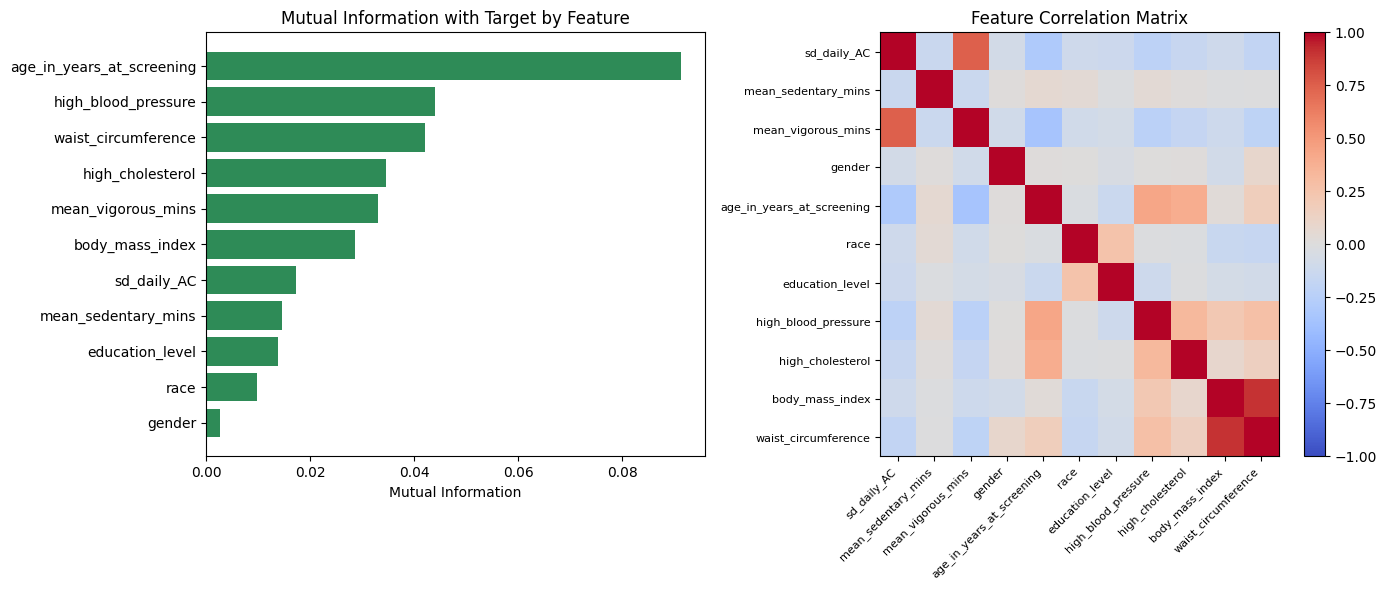

In [ ]:
# 6.33 - (Optional) Feature Importance Analysis
# Determine which features are most predictive of diabetes

import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif
import numpy as np

print("Feature columns:", X.columns.tolist())
print(f"Number of features: {X.shape[1]}")

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Mutual Information
ax1 = axes[0]
mi_scores = mutual_info_classif(X_train, y_train, random_state=42)
feature_importance_mi = pd.DataFrame({
    'feature': X.columns,
    'mutual_info': mi_scores
}).sort_values('mutual_info', ascending=False)
feature_importance_mi_sorted = feature_importance_mi.sort_values('mutual_info', ascending=True)
ax1.barh(feature_importance_mi_sorted['feature'], feature_importance_mi_sorted['mutual_info'], color='seagreen')
ax1.set_xlabel('Mutual Information')
ax1.set_title('Mutual Information with Target by Feature')

# Feature Correlation Matrix
ax2 = axes[1]
corr_matrix = X_train.corr()
im = ax2.imshow(corr_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
ax2.set_xticks(range(len(X.columns)))
ax2.set_yticks(range(len(X.columns)))
ax2.set_xticklabels(X.columns, rotation=45, ha='right', fontsize=8)
ax2.set_yticklabels(X.columns, fontsize=8)
ax2.set_title('Feature Correlation Matrix')
plt.colorbar(im, ax=ax2)

plt.tight_layout()
plt.show()

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# 6.67 - (Optional) Hyperparameter Tuning for Random Forest with GridSearchCV

param_grid = {
    'n_estimators': [100, 300, 500, 700],
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced']
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    verbose=2
)
grid_search.fit(X_train, y_train)

print("Best parameters found:")
print(grid_search.best_params_)

# Best parameters found:
# {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 700}

Fitting 3 folds for each of 180 candidates, totalling 540 fits
Best parameters found:
{'class_weight': 'balanced', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 700}


In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

# 7. Train Random Forest Model

rf_model = RandomForestClassifier(
    n_estimators=700, 
    class_weight="balanced", 
    random_state=42, 
    max_depth=10, 
    min_samples_leaf=4, 
    min_samples_split=10
)
rf_model.fit(X_train, y_train)

# Get probability predictions (threshold tuning done on ensemble)
y_test_prob_rf = rf_model.predict_proba(X_test)[:, 1]
y_val_prob_rf = rf_model.predict_proba(X_val)[:, 1]

print("Random Forest Model Trained")
print("Validation ROC AUC:", roc_auc_score(y_val, y_val_prob_rf))
print("Test ROC AUC:", roc_auc_score(y_test, y_test_prob_rf))


# Validation ROC AUC: 0.7910640969907743
# Test ROC AUC: 0.8022798628218132

Random Forest Model Trained
Validation ROC AUC: 0.7910640969907743
Test ROC AUC: 0.8022798628218132


In [12]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# 7.5 - (Optional) Hyperparameter Tuning for XGBoost with GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'scale_pos_weight': [1, 2, 5]
}

xgb = XGBClassifier(random_state=42, eval_metric='logloss')
grid_search = GridSearchCV(xgb, param_grid, scoring='roc_auc', cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters found:")
print(grid_search.best_params_)

# Best parameters found:
# {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'scale_pos_weight': 1}

Best parameters found:
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'scale_pos_weight': 1}


In [13]:
# 8. Train XGBoost Model

from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

xgb_model = XGBClassifier(
    colsample_bytree=0.8,
    min_child_weight=1,
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    scale_pos_weight=1,
    random_state=42,
    eval_metric='logloss',
    subsample=0.6
)
xgb_model.fit(X_train, y_train)

# Get probability predictions (threshold tuning done on ensemble)
y_test_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]
y_val_prob_xgb = xgb_model.predict_proba(X_val)[:, 1]

print("XGBoost Model Trained")
print("Validation ROC AUC:", roc_auc_score(y_val, y_val_prob_xgb))
print("Test ROC AUC:", roc_auc_score(y_test, y_test_prob_xgb))

# Validation ROC AUC: 0.794677099937207
# Test ROC AUC: 0.8045669709703906

XGBoost Model Trained
Validation ROC AUC: 0.794677099937207
Test ROC AUC: 0.8045669709703906


In [14]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

# 8.5 - (Optional) Hyperparameter Tuning for MLP Neural Network with GridSearchCV

X_train_scaled = X_train
X_val_scaled = X_val
X_test_scaled = X_test

param_grid = {
    'hidden_layer_sizes': [(64,), (64, 32), (64, 32, 16), (128, 64), (128, 64, 32)],
    'activation': ['relu', 'tanh'],
    'learning_rate': ['constant', 'adaptive'],
    'learning_rate_init': [0.001, 0.01],
    'alpha': [0.0001, 0.001, 0.01],
}

# Use early_stopping in the base estimator to prevent overfitting
mlp = MLPClassifier(
    random_state=42,
    max_iter=500,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=10
)

grid_search = GridSearchCV(mlp, param_grid, scoring='average_precision', cv=5, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

print("Best parameters found:")
print(grid_search.best_params_)

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

# 8.5 - (Optional) Hyperparameter Tuning for MLP Neural Network with GridSearchCV

X_train_scaled = X_train
X_val_scaled = X_val
X_test_scaled = X_test

param_grid = {
    'hidden_layer_sizes': [(64,), (64, 32), (64, 32, 16), (128, 64), (128, 64, 32)],
    'activation': ['relu', 'tanh'],
    'learning_rate': ['constant', 'adaptive'],
    'learning_rate_init': [0.001, 0.01],
    'alpha': [0.0001, 0.001, 0.01],
}

# Use early_stopping in the base estimator to prevent overfitting
mlp = MLPClassifier(
    random_state=42,
    max_iter=500,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=10
)

grid_search = GridSearchCV(mlp, param_grid, scoring='average_precision', cv=5, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

print("Best parameters found:")
print(grid_search.best_params_)

# Best parameters found:
# {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (128, 64, 32), 'learning_rate': 'constant', 'learning_rate_init': 0.001}

Best parameters found:
{'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (128, 64, 32), 'learning_rate': 'constant', 'learning_rate_init': 0.001}
Best parameters found:
{'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (128, 64, 32), 'learning_rate': 'constant', 'learning_rate_init': 0.001}


In [15]:
# 9. Train Neural Network (MLP)

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score

X_train_scaled = X_train
X_val_scaled = X_val
X_test_scaled = X_test

# Calculate class weights for the loss function
from sklearn.utils.class_weight import compute_sample_weight
sample_weights = compute_sample_weight('balanced', y_train)

mlp_model = MLPClassifier(
    hidden_layer_sizes=(128, 64, 32),
    activation='tanh',
    solver='adam',
    learning_rate='constant',
    learning_rate_init=0.001,
    max_iter=500,
    early_stopping=True,
    validation_fraction=0.1,
    random_state=42,
    verbose=False,
    alpha=0.001,
)
mlp_model.fit(X_train_scaled, y_train)

# Get probability predictions (threshold tuning done on ensemble)
y_test_prob_mlp = mlp_model.predict_proba(X_test_scaled)[:, 1]
y_val_prob_mlp = mlp_model.predict_proba(X_val_scaled)[:, 1]

print("MLP Model Trained")
print("Validation ROC AUC:", roc_auc_score(y_val, y_val_prob_mlp))
print("Test ROC AUC:", roc_auc_score(y_test, y_test_prob_mlp))

# Validation ROC AUC: 0.7915616094285853
# Test ROC AUC: 0.79637492150896

MLP Model Trained
Validation ROC AUC: 0.7915616094285853
Test ROC AUC: 0.79637492150896


In [ ]:
# 10. Ensemble Methods - Combining RF, XGBoost, and MLP
from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score, confusion_matrix, roc_auc_score 

# Calcuklate Equally Wieghted Average Predictions
ensemble_weighted_val = (y_val_prob_rf + y_val_prob_xgb + y_val_prob_mlp) / 3
ensemble_weighted_test = (y_test_prob_rf + y_test_prob_xgb + y_test_prob_mlp) / 3

# Find threshold that achieves target recall
target_recall=0.85
best_t, best_f1 = 0.0, -1.0
for t in np.linspace(0.01, 0.95, 500):
    preds = (ensemble_weighted_val >= t).astype(int)
    rec = recall_score(y_val, preds)
    if rec >= target_recall:
        f1 = f1_score(y_val, preds)
        if f1 > best_f1:
            best_f1 = f1
            best_t = t


y_pred = (ensemble_weighted_test >= best_t).astype(int)

prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
pr_auc = average_precision_score(y_test, ensemble_weighted_test)
roc_auc = roc_auc_score(y_test, ensemble_weighted_test)

print(f"\nFinal Equally Weighted Avg. Ensemble Model Results:")
print(f"Threshold: {best_t:.3f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1: {f1:.4f}")
print(f"PR AUC: {pr_auc:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}")

# Final Equally Weighted Avg. Ensemble Model Results:
# Threshold: 0.328
# Precision: 0.5846
# Recall: 0.8524
# F1: 0.6935
# PR AUC: 0.7032
# ROC AUC: 0.8040
# Confusion Matrix:
# [[492 312]
#  [ 76 439]]


Final Equally Weighted Avg. Ensemble Model Results:
Threshold: 0.048
Precision: 0.4066
Recall: 0.9981
F1: 0.5779
PR AUC: 0.7032
ROC AUC: 0.8040
Confusion Matrix:
[[ 54 750]
 [  1 514]]
